# Local Quantile Projections: Example

This notebook presents a (simple) application of local quantile projections

It uses a Python package that I have written, quantileproj.py, also available in this Github folder (modules/). quantileproj is based on the Quantreg modules of statsmodels. The package also relies on my conditional quantile sampling module (https://github.com/romainlafarguette/cqsampling)

The quantile uncrossing part is based on either:

Chernozhukov et al. (2010) Quantile and Probability Curves Without Crossing, Econometrica

Schmidt and Zhu (2016), Quantile Spacings: A Simple Method for the Joint Estimation of Multiple Quantiles Without Crossing

Author: Romain Lafarguette, August 2020, https://github.com/romainlafarguette

If you have any question, please contact me via Github 

## Preamble

In [20]:
# Main packages
import os, sys, importlib                               # System tools
import pandas as pd                                     # Dataframes
import numpy as np                                      # Numeric tools
import statsmodels.api as sm                            # Statistics

# Graphics
%matplotlib inline
import matplotlib.pyplot as plt                         # Graphical package  
import seaborn as sns                                   # Graphical tools
plt.rcParams["figure.figsize"]=25,15 

# Local modules
sys.path.append(os.path.abspath('modules'))             # Executable path
import quantileproj; importlib.reload(quantileproj)     # Quantile projections
from quantileproj import QuantileProj

## Parameters

In [21]:
quantile_l = list(np.arange(0.05, 1, 0.05)) # Every 5% quantiles (put less if you have "bad data")
horizon_l = [1, 2, 4, 8, 12] # 1M - 1Y for monthly data

## Example data set (US macro data from statsmodels)

In [25]:
df = sm.datasets.macrodata.load_pandas().data.copy()

# Create a date index with end of quarter convention
dates_l = [f'{y:.0f}-Q{q:.0f}' for y,q in zip(df['year'], df['quarter'])]
df = df.set_index(pd.to_datetime(dates_l) + pd.offsets.QuarterEnd())

# Clean some variables
df['rgdp_growth'] = df['realgdp'].rolling(4).sum().pct_change(4)
df = df.rename(columns={'infl':'inflation', 'unemp':'unemployment'})
df['current_inflation'] = df['inflation'].copy() # To avoid name confusion dependent/regressor
print(df.describe())
print(df.tail())


              year     quarter       realgdp     realcons      realinv  \
count   203.000000  203.000000    203.000000   203.000000   203.000000   
mean   1983.876847    2.492611   7221.171901  4825.293103  1012.863862   
std      14.686817    1.118563   3214.956044  2313.346192   585.102267   
min    1959.000000    1.000000   2710.349000  1707.400000   259.764000   
25%    1971.000000    1.500000   4440.103500  2874.100000   519.147500   
50%    1984.000000    2.000000   6559.594000  4299.900000   896.210000   
75%    1996.500000    3.000000   9629.346500  6398.150000  1436.681500   
max    2009.000000    4.000000  13415.266000  9363.600000  2264.721000   

          realgovt       realdpi         cpi           m1    tbilrate  \
count   203.000000    203.000000  203.000000   203.000000  203.000000   
mean    663.328640   5310.540887  105.075788   667.927586    5.311773   
std     140.863655   2423.515977   61.278878   455.346381    2.803071   
min     460.400000   1886.900000   28.980

## Quantile model specification and fit

In [26]:
dependent = 'inflation'
regressors_l = ['current_inflation', 'rgdp_growth', 'unemployment', 'realint']

qr = QuantileProj(dependent, regressors_l, df, horizon_l)

qr_fit = qr.fit(quantile_l=quantile_l, alpha=0.05)

7 missing obs on depvar and indvar
95 quantile regressions estimated for 5 horizons and 19 quantiles


### All the coefficients, tstats, pvalues and R2 are packaged into a large dataframe

In [27]:
qr_fit.coeffs

,tau,horizon,coeff,tval,pval,lower_ci,upper_ci,pseudo_r2
Intercept,0.05,1,0.841561,0.499083,0.618298,-2.484546,4.167669,0.087149
current_inflation,0.05,1,0.498922,4.931470,0.000002,0.299359,0.698485,0.087149
rgdp_growth,0.05,1,3.799437,0.227499,0.820280,-29.143480,36.742354,0.087149
unemployment,0.05,1,-0.502487,-2.557945,0.011309,-0.889973,-0.115000,0.087149
realint,0.05,1,0.464137,2.650024,0.008727,0.118660,0.809614,0.087149
...,...,...,...,...,...,...,...,...
Intercept,0.95,12,3.532466,1.093881,0.275477,-2.839924,9.904856,0.214528
current_inflation,0.95,12,-0.327144,-2.283086,0.023601,-0.609899,-0.044389,0.214528
rgdp_growth,0.95,12,-14.588670,-0.449995,0.653258,-78.562487,49.385147,0.214528
unemployment,0.95,12,1.527607,3.294593,0.001188,0.612642,2.442571,0.214528


## Local projections based on a conditioning frame

In [28]:
# Design a conditioning frame (here last observation for instance)
cond_frame = df.loc[[max(df.index)], regressors_l].copy()
qr_proj = qr_fit.proj(cond_frame)

### The fitted conditional quantiles are available in the object directly, with the asymptotics and sampled statistics

In [29]:
qr_proj.cond_quant

tau  horizon  conditional_quantile_mean  \
horizon tau                                              
1       0.05  0.05        1                  -3.912063   
        0.10  0.10        1                  -0.016468   
        0.15  0.15        1                   0.838409   
        0.20  0.20        1                   1.482563   
        0.25  0.25        1                   1.648238   
...            ...      ...                        ...   
12      0.75  0.75       12                  10.882492   
        0.80  0.80       12                  10.988227   
        0.85  0.85       12                  12.846346   
        0.90  0.90       12                  18.434627   
        0.95  0.95       12                  20.232781   

              conditional_quantile_mean_se  \
horizon tau                                  
1       0.05                      1.260987   
        0.10                      1.033498   
        0.15                      0.848262   
        0.20                      0.850673   
        0.25                      0.736804   
...                                    ...   
12      0.75                      1.411929   
        0.80                      1.556833   
        0.85                      1.754242   
        0.90                      2.027135   
        0.95                      2.115421   

              conditional_quantile_mean_ci_lower  \
horizon tau                                        
1       0.05                           -6.399396   
        0.10                           -2.055072   
        0.15                           -0.834812   
        0.20                           -0.195413   
        0.25                            0.194872   
...                                          ...   
12      0.75                            8.096324   
        0.80                            7.916120   
        0.85                            9.384691   
        0.90                           14.434470   
        0.95                           16.058410   

              conditional_quantile_mean_ci_upper  \
horizon tau                                        
1       0.05                           -1.424731   
        0.10                            2.022137   
        0.15                            2.511630   
        0.20                            3.160540   
        0.25                            3.101605   
...                                          ...   
12      0.75                           13.668660   
        0.80                           14.060335   
        0.85                           16.308001   
        0.90                           22.434784   
        0.95                           24.407152   

              conditional_quantile_obs_ci_lower  \
horizon tau                                       
1       0.05                          -7.086601   
        0.10                          -2.853152   
        0.15                          -1.748198   
        0.20                          -1.107123   
        0.25                          -0.801893   
...                                         ...   
12      0.75                           7.468306   
        0.80                           7.336957   
        0.85                           8.861752   
        0.90                          13.974225   
        0.95                          15.615497   

              conditional_quantile_obs_ci_upper  
horizon tau                                      
1       0.05                          -0.737526  
        0.10                           2.820216  
        0.15                           3.425016  
        0.20                           4.072249  
        0.25                           4.098369  
...                                         ...  
12      0.75                          14.296678  
        0.80                          14.639498  
        0.85                          16.830940  
        0.90                          22.895029  
        0.95                          24.85

### Plot the quantile coefficients and R2

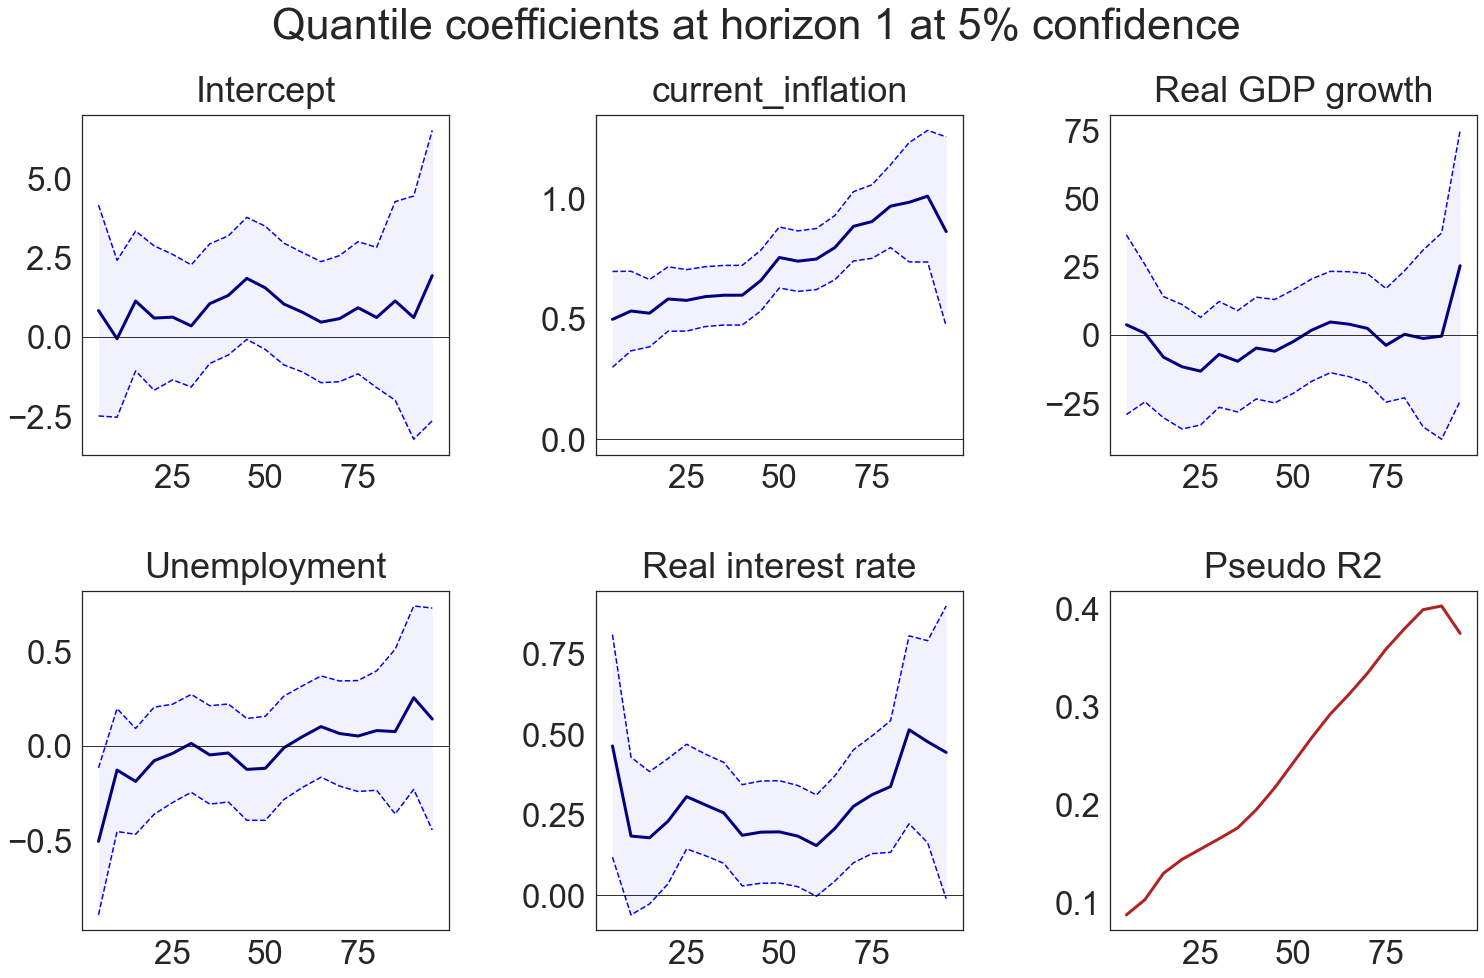

In [30]:
label_d = {'rgdp_growth': 'Real GDP growth',
           'unemployment': 'Unemployment',
           'realint': 'Real interest rate'}

sns.set(style='white', font_scale=3, palette='deep', font='Arial') # Style
qr_fit.plot.coeffs_grid(horizon=1, label_d=label_d)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()


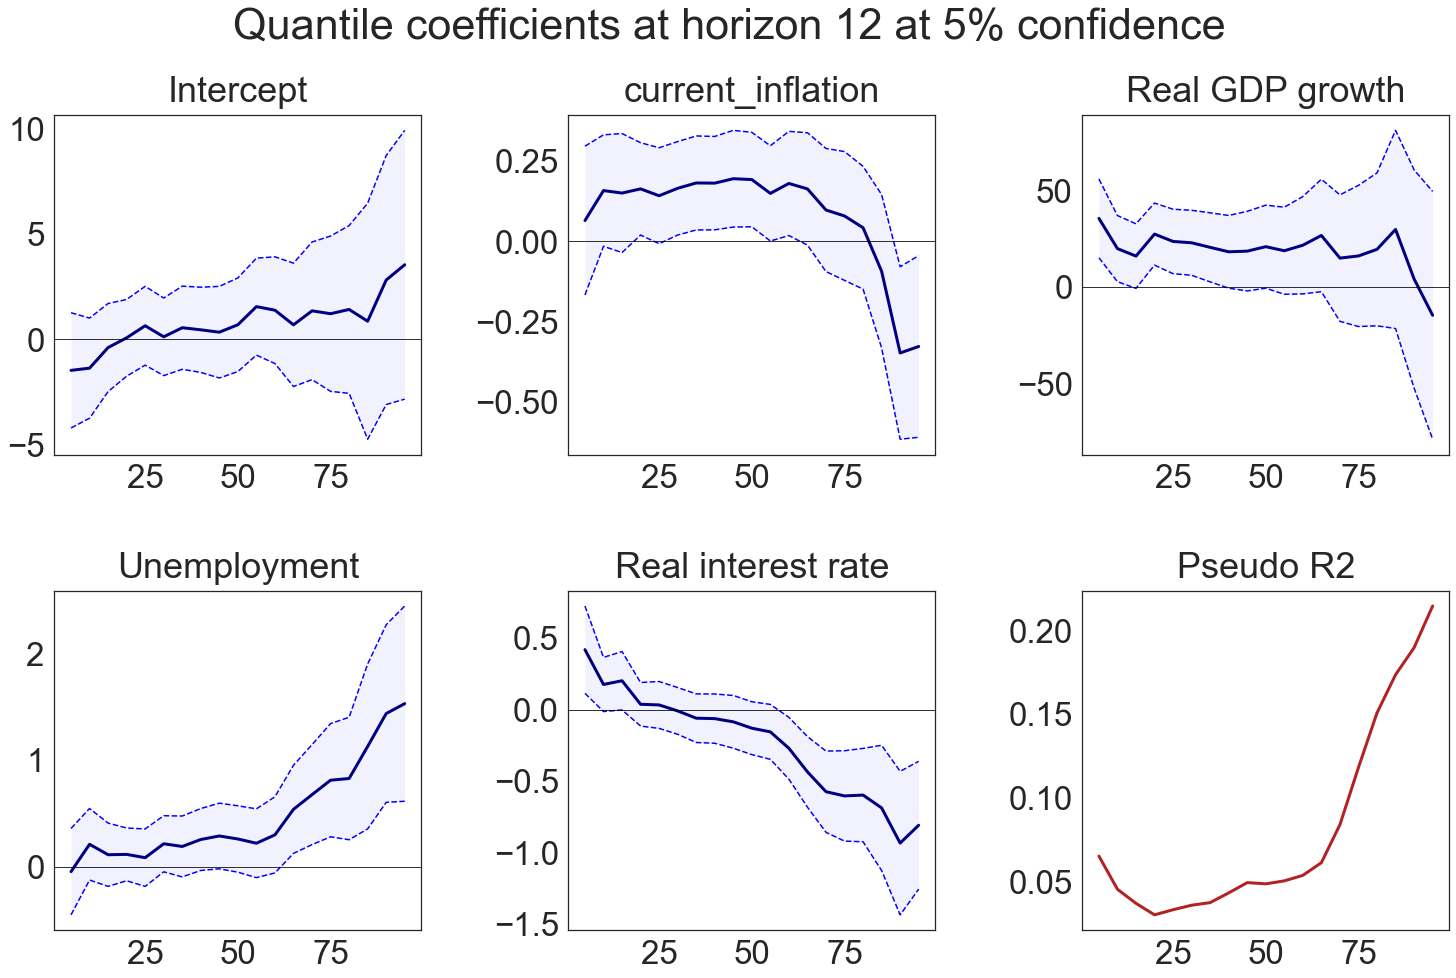

In [31]:
sns.set(style='white', font_scale=3, palette='deep', font='Arial') # Style
qr_fit.plot.coeffs_grid(horizon=12, label_d=label_d)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

### Conditional quantiles plot (fitted from quantile regressions)

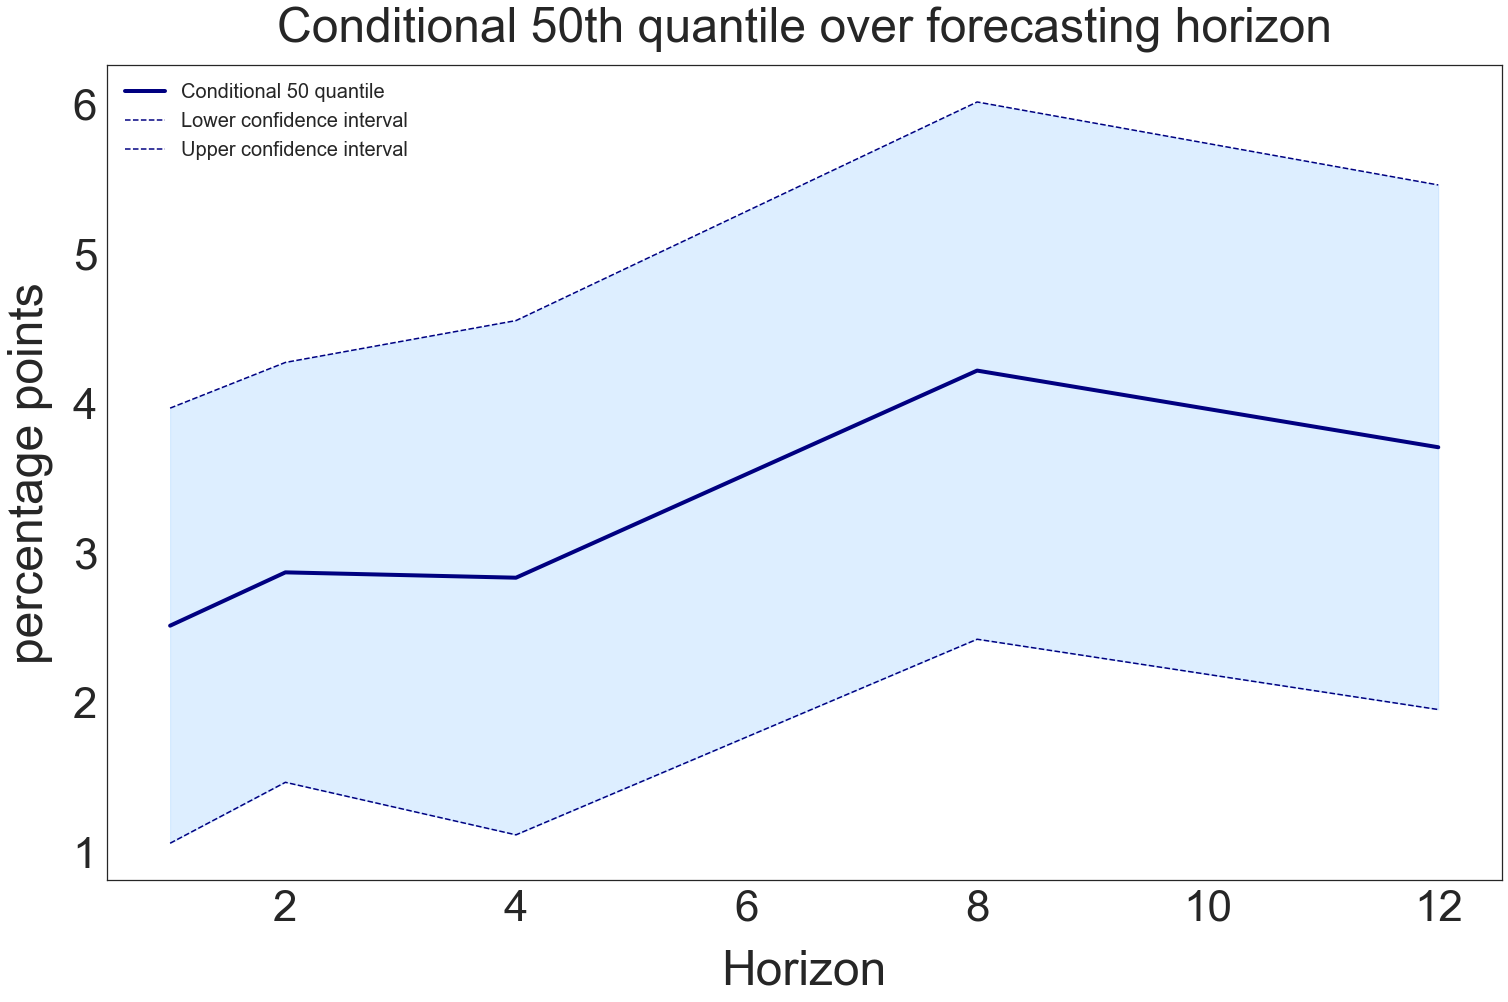

In [32]:
sns.set(style='white', font_scale=4, palette='deep', font='Arial') # Style
qr_proj.plot.fitted_quantile(quantile=0.5, ylabel='percentage points', legendfont=20)
plt.show()

### Fan chart (based on resampled conditional quantiles)

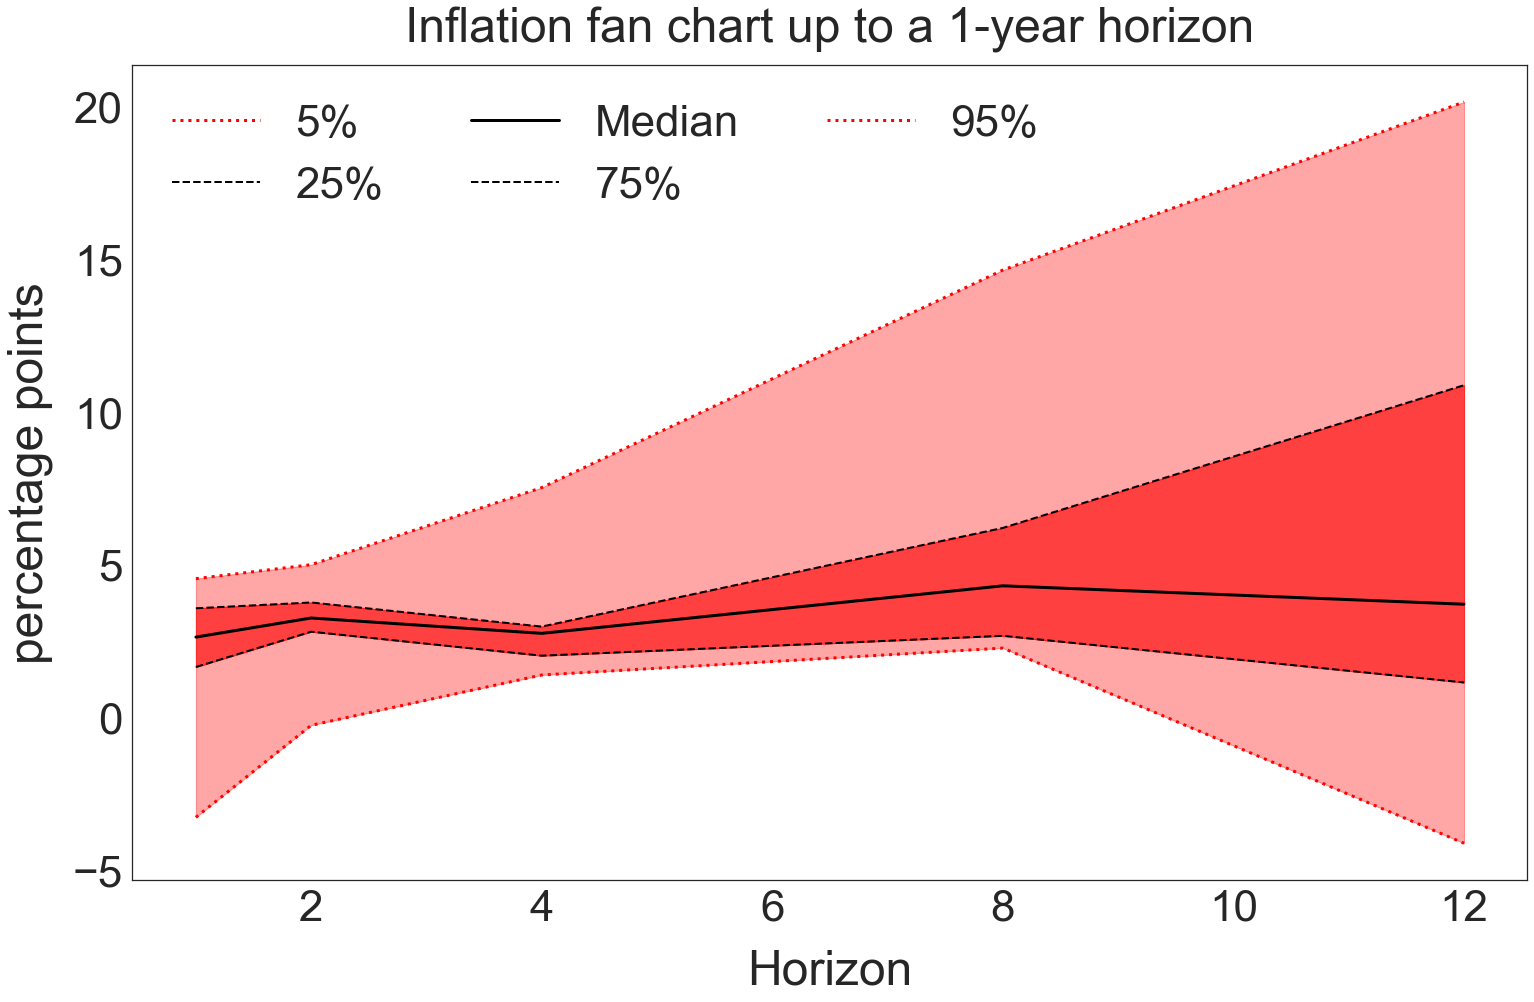

In [33]:
sns.set(style='white', font_scale=4, palette='deep', font='Arial') # Style
qr_proj.plot.fan_chart(title='Inflation fan chart up to a 1-year horizon', ylabel='percentage points', 
                       len_sample=10000, seed=18041202)
plt.show()

#### The file ends here